In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
class CliffWalkingEnv():
    def __init__(self,ncol,nrow):
        self.nrow=nrow
        self.ncol=ncol
        self.x=0
        self.y=self.nrow-1
    def step(self,action):
        change=[[0,-1],[0,1],[1,0],[-1,0]]
        self.x=min(self.ncol-1,max(0,self.x+change[action][0]))
        self.y=min(self.nrow-1,max(0,self.y+change[action][1]))
        new_state=self.y*self.ncol+self.x
        reward=-1
        done=False
        if self.y==self.nrow-1 and self.x>0:
            done=True
            if self.x!=self.ncol-1:
                reward=-100
        return new_state,reward,done
    def reset(self):
        self.x=0
        self.y=self.nrow-1
        return self.y*self.ncol+self.x
        
        
        

## Sarsa

In [3]:
class Sarsa():
    def __init__(self,ncol,nrow,eps,alpha,gamma,n_action=4):
        self.Q_table=np.zeros((ncol*nrow,n_action))
        self.n_action=n_action
        self.alpha=alpha
        self.eps=eps
        self.gamma=gamma
    def take_action(self,state):
        if np.random.random()<self.eps:
            action=np.random.randint(0,self.n_action)
        else:
            action=np.argmax(self.Q_table[state])
        return action
    def best_action(self,state):
        Q_max=np.max(self.Q_table[state])
        a=[1 if q==Q_max else 0 for q in self.Q_table[state]]
        return a
    
    def update(self,s0,a0,r,s1,a1):
        #时序差分值
        td_error=r+self.gamma*self.Q_table[s1,a1]-self.Q_table[s0,a0]
        self.Q_table[s0,a0]+=self.alpha*td_error
        

iter 9: 100%|██████████| 50/50 [00:00<00:00, 1841.29it/s, epoch=500, return=-20.700]


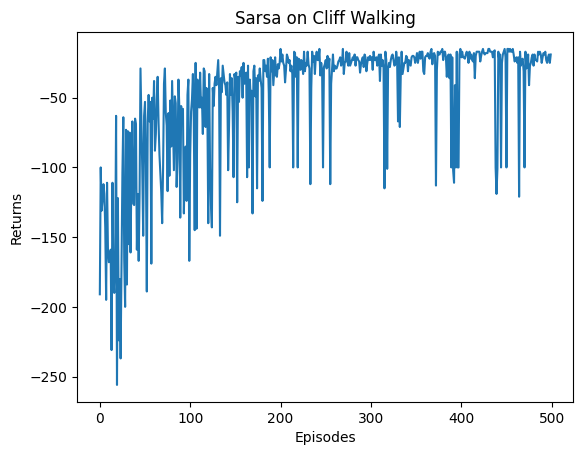

In [4]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(10)
eps= 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, eps, alpha, gamma)
epochs = 500  # 智能体在环境中运行的序列的数量

return_list=[]
for i in range(10):
    with tqdm(total=epochs//10,desc='iter %d'%i) as pbar:
        for epoch in range(epochs//10):
            rewards=0
            state=env.reset()
            action=agent.take_action(state)
            done=False
            while not done:
                new_state,r,done=env.step(action)
                new_action=agent.take_action(new_state)
                rewards+=r
                agent.update(state,action,r,new_state,new_action)
                state=new_state
                action=new_action
            return_list.append(rewards)
            if (epoch+1) %10==0:
                pbar.set_postfix({
                    'epoch':'%d'%(epochs//10*i+epoch+1),
                    'return':'%.3f'%np.mean(return_list[-10:])
                })
            pbar.update(1)
plt.plot(range(len(return_list)),return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [5]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '>', '<']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Sarsa算法最终收敛得到的策略为：
oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o ovoo ovoo 
oo>o oo>o oo>o oo>o ^ooo ^ooo ^ooo ^ooo oo>o oo>o oo>o ovoo 
^ooo ^ooo ^ooo ^ooo ^ooo ooo< oo>o ^ooo oo>o oo>o oo>o ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


## n_step_Sarsa

In [6]:
class n_step_Sarsa():
    def __init__(self,n,ncol,nrow,eps,alpha,gamma,n_action=4):
        self.Q_table=np.zeros((ncol*nrow,n_action))
        self.n_action=n_action
        self.alpha=alpha
        self.eps=eps
        self.gamma=gamma
        self.n=n
        self.state_list=[]
        self.reward_list=[]
        self.action_list=[]
    def take_action(self,state):
        if np.random.random()<self.eps:
            action=np.random.randint(0,self.n_action)
        else:
            action=np.argmax(self.Q_table[state])
        return action
    def best_action(self,state):
        Q_max=np.max(self.Q_table[state])
        a=[1 if q==Q_max else 0 for q in self.Q_table[state]]
        return a
    
    def update(self,s0,a0,r,s1,a1,done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        if len(self.state_list)==self.n:
            res=self.Q_table[s1,a1]
            for i in reversed(range(self.n)):
                res=res*self.gamma+self.reward_list[i]
                #到达终止状态更新后面的步数
                if done and i>0:
                    s=self.state_list[i]
                    a=self.action_list[i]
                    self.Q_table[s,a]+=self.alpha*(res-self.Q_table[s,a])
            s=self.state_list.pop(0)
            a=self.action_list.pop(0)
            r=self.reward_list.pop(0)
            self.Q_table[s,a]+=self.alpha*(res-self.Q_table[s,a])
            
        if done:
            self.state_list=[]
            self.reward_list=[]
            self.action_list=[]
        

iter 9: 100%|██████████| 500/500 [00:00<00:00, 1254.02it/s, epoch=5000, return=-20.000] 


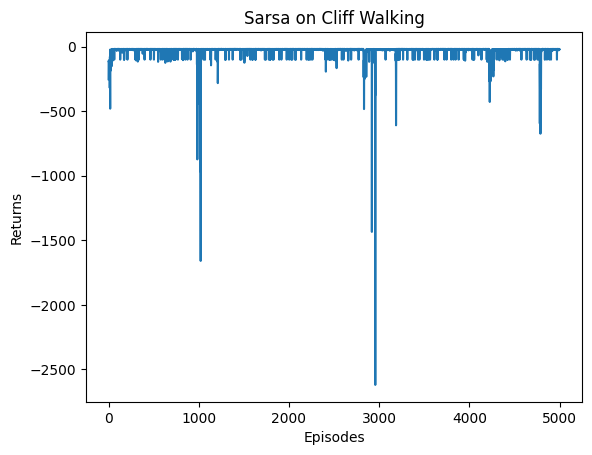

In [10]:
np.random.seed(10)
n_step = 3  # 5步Sarsa算法
alpha = 0.1
epsilon = 0.1
gamma = 0.9
agent = n_step_Sarsa(n_step, ncol, nrow, epsilon, alpha, gamma)
epochs = 5000 # 智能体在环境中运行的序列的数量

return_list=[]
for i in range(10):
    with tqdm(total=epochs//10,desc='iter %d'%i) as pbar:
        for epoch in range(epochs//10):
            rewards=0
            state=env.reset()
            action=agent.take_action(state)
            done=False
            while not done:
                new_state,r,done=env.step(action)
                new_action=agent.take_action(new_state)
                rewards+=r
                agent.update(state,action,r,new_state,new_action,done)
                state=new_state
                action=new_action
            return_list.append(rewards)
            if (epoch+1) %10==0:
                pbar.set_postfix({
                    'epoch':'%d'%(epochs//10*i+epoch+1),
                    'return':'%.3f'%np.mean(return_list[-10:])
                })
            pbar.update(1)
plt.plot(range(len(return_list)),return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [11]:
action_meaning = ['^', 'v', '>', '<']
print('5步Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

5步Sarsa算法最终收敛得到的策略为：
ovoo oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o ovoo 
oo>o ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo< ^ooo ooo< oo>o ovoo 
^ooo ooo< oo>o oo>o ^ooo oo>o ^ooo ^ooo ^ooo ^ooo oo>o ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


## Q-learning

In [9]:
class Q_learning():
    def __init__(self,ncol,nrow,eps,alpha,gamma,n_action=4):
        self.Q_table=np.zeros((ncol*nrow,n_action))
        self.n_action=n_action
        self.alpha=alpha
        self.eps=eps
        self.gamma=gamma
    def take_action(self,state):
        if np.random.random()<self.eps:
            action=np.random.randint(0,self.n_action)
        else:
            action=np.argmax(self.Q_table[state])
        return action
    def best_action(self,state):
        Q_max=np.max(self.Q_table[state])
        a=[1 if q==Q_max else 0 for q in self.Q_table[state]]
        return a
    
    def update(self,s0,a0,r,s1):
        td_error=r+self.gamma*self.Q_table[s1].max()-self.Q_table[s0][a0]
        self.Q_table[s0][a0]+=self.alpha*td_error
        

iter 9: 100%|██████████| 500/500 [00:00<00:00, 2378.22it/s, epoch=5000, return=-60.500]


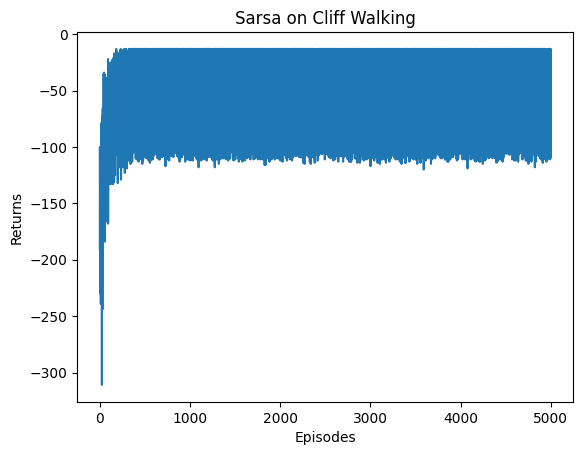

In [12]:
np.random.seed(10)
alpha = 0.1
epsilon = 0.1
gamma = 0.9
agent = Q_learning( ncol, nrow, epsilon, alpha, gamma)
epochs = 5000 # 智能体在环境中运行的序列的数量

return_list=[]
for i in range(10):
    with tqdm(total=epochs//10,desc='iter %d'%i) as pbar:
        for epoch in range(epochs//10):
            rewards=0
            state=env.reset()
            action=agent.take_action(state)
            done=False
            while not done:
                new_state,r,done=env.step(action)
                new_action=agent.take_action(new_state)
                rewards+=r
                agent.update(state,action,r,new_state)
                state=new_state
                action=new_action
            return_list.append(rewards)
            if (epoch+1) %10==0:
                pbar.set_postfix({
                    'epoch':'%d'%(epochs//10*i+epoch+1),
                    'return':'%.3f'%np.mean(return_list[-10:])
                })
            pbar.update(1)
plt.plot(range(len(return_list)),return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [13]:
action_meaning = ['^', 'v', '>', '<']
print('Q-learning算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Q-learning算法最终收敛得到的策略为：
^ooo ooo< oo>o oo>o oo>o oo>o ovoo ovoo oo>o oo>o ovoo ovoo 
oo>o ovoo oo>o ovoo oo>o ovoo oo>o oo>o oo>o oo>o ovoo ovoo 
oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


## Dyna-Q

In [29]:
import random
class Dyna_Q():
    def __init__(self,ncol,nrow,eps,alpha,gamma,n_planning=20,n_action=4):
        self.Q_table=np.zeros((ncol*nrow,n_action))
        self.n_action=n_action
        self.alpha=alpha
        self.eps=eps
        self.gamma=gamma
        self.model=dict()
        self.n_planning=n_planning
    def take_action(self,state):
        if np.random.random()<self.eps:
            action=np.random.randint(0,self.n_action)
        else:
            action=np.argmax(self.Q_table[state])
        return action
    def best_action(self,state):
        Q_max=np.max(self.Q_table[state])
        a=[1 if q==Q_max else 0 for q in self.Q_table[state]]
        return a
    
    def q_learning(self,s0,a0,r,s1):
        td_error=r+self.gamma*self.Q_table[s1].max()-self.Q_table[s0][a0]
        self.Q_table[s0][a0]+=self.alpha*td_error
    
    def update(self,s0,a0,r,s1):
        self.q_learning(s0,a0,r,s1)
        self.model[(s0,a0)]=(r,s1)
        for _ in range(self.n_planning):
            (s0,a0),(r,s1)=random.choice((list(self.model.items())))
            self.q_learning(s0,a0,r,s1)

Q-planning步数为：0


iter 9: 100%|██████████| 50/50 [00:00<00:00, 2224.34it/s, epoch=500, return=-13.200]


Q-planning步数为：2


iter 9: 100%|██████████| 50/50 [00:00<00:00, 1047.07it/s, epoch=500, return=-22.700]


Q-planning步数为：20


iter 9: 100%|██████████| 50/50 [00:00<00:00, 196.73it/s, epoch=500, return=-13.200]


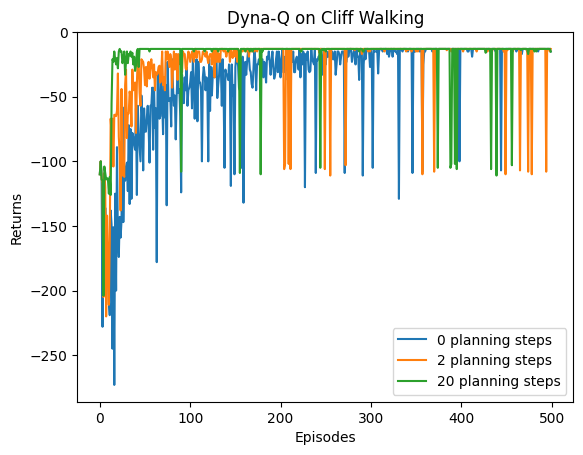

In [35]:
def train_Dyna_Q(n_planning):
    np.random.seed(10)
    alpha = 0.1
    eps = 0.01
    gamma = 0.9
    n_planning=n_planning
    agent = Dyna_Q( ncol, nrow, epsilon, alpha, gamma,n_planning)
    epochs = 500 # 智能体在环境中运行的序列的数量

    return_list=[]
    for i in range(10):
        with tqdm(total=epochs//10,desc='iter %d'%i) as pbar:
            for epoch in range(epochs//10):
                rewards=0
                state=env.reset()
                action=agent.take_action(state)
                done=False
                while not done:
                    new_state,r,done=env.step(action)
                    new_action=agent.take_action(new_state)
                    rewards+=r
                    agent.update(state,action,r,new_state)
                    state=new_state
                    action=new_action
                return_list.append(rewards)
                if (epoch+1) %10==0:
                    pbar.set_postfix({
                        'epoch':'%d'%(epochs//10*i+epoch+1),
                        'return':'%.3f'%np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list,agent
import time
np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 20]
agents=[]
for n_planning in n_planning_list:
    print('Q-planning步数为：%d' % n_planning)
    time.sleep(0.5)
    return_list,agent = train_Dyna_Q(n_planning)
    agents.append(agent)
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list,
             return_list,
             label=str(n_planning) + ' planning steps')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('Cliff Walking'))
plt.show()


In [36]:
action_meaning = ['^', 'v', '>', '<']

for agent,n_planning in zip(agents,n_planning_list):
    print('Q-planning步数为：%d' % n_planning)
    print('最终收敛得到的策略为：')
    print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Q-planning步数为：0
最终收敛得到的策略为：
oo>o ^ooo oo>o oo>o oo>o ovoo ovoo ovoo ovoo oo>o oo>o ovoo 
ovoo oo>o oo>o oo>o oo>o ^ooo oo>o oo>o ovoo ooo< ovoo ovoo 
oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 
Q-planning步数为：2
最终收敛得到的策略为：
oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o ovoo 
oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o ovoo ovoo 
oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 
Q-planning步数为：20
最终收敛得到的策略为：
ov>o ov>o ov>o ov>o ov>o ov>o ov>o ov>o ov>o ov>o ov>o ovoo 
ov>o ov>o ov>o ov>o ov>o ov>o ov>o ov>o ov>o ov>o ov>o ovoo 
oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o oo>o ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 
